## Find Theoretical PDF for SendRequestSeconds  
  
In the main notebook, we rely heavily on this value.  The SendRequestSeconds shows how many seconds elapsed between when the email was sent to the contact and the date the click requests came in. 
  
This is very much a skewed PDF with the bulk of the click requests coming in very soon after the message was sent.  This is somewhat expected since contact at their work desks usually see the message within a few minutes of the actual send date. 
  
But this is also a critical feature used to help determine if the click request is from a BOT.  Since BOTs are automated, many of them will do their clicks as soon as the message arrives. 
  
In the plots below, we see that even using a y log scale, the data is still skewed heavly to towards the send date. 
  
In the main notebook, we use a natural log to tame this feature down and this approach seems to work well. 
  
But here are looking to see if we can predict the theoretical PDF using Bayesian poster parameters and pymc3. 
  
Chances are, the PDF is an exponential-decay based PDF.  But we will use the Gamma distribution here to give us a bit more flexibility.   

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import expon, gamma 

## Load Dataset From BotDataSet class

In [2]:
exec(open("BotDataSet.py").read())

In [3]:
botDataSet = BotDataSet()
botDataSet.loadCSV('C:/data/C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8.csv')
df = botDataSet.df

In [4]:
SendRequestSeconds = df.SendRequestSeconds.values #Send to Click Time

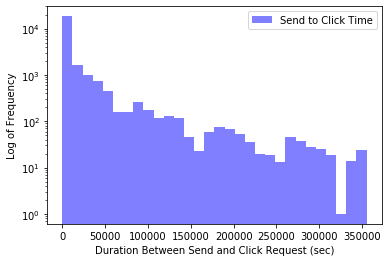

In [5]:
plt.hist(SendRequestSeconds, bins=30, alpha=0.5, label='Send to Click Time', color='b')
plt.xlabel('Duration Between Send and Click Request (sec)')
plt.ylabel('Log of Frequency')
plt.yscale('log', nonposy='clip')
plt.legend()
plt.show()

### Not even a log scale can flatten the histogram
### Lets see if we can fit this with a Gamma function

In [6]:
alpha_est = np.mean(SendRequestSeconds)**2 / np.var(SendRequestSeconds)
beta_est = np.var(SendRequestSeconds) / np.mean(SendRequestSeconds)
alpha_est, beta_est

(0.15233591885937647, 106400.81917112328)

In [7]:
seed(42)
# beta_est = beta_est * 1.7
gamma_simulation = gamma(alpha_est, scale=beta_est).rvs(len(SendRequestSeconds))
# Dataframe was terminated about 2 days after the send, so lets apply the same date range to our simulation
max_SendRequestSeconds = SendRequestSeconds.max()
gamma_simulation_truncated = gamma_simulation[gamma_simulation < max_SendRequestSeconds]

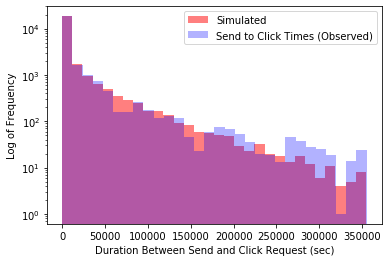

In [8]:
plt.hist(gamma_simulation_truncated, bins=30, alpha=0.5, label='Simulated', color='r')
plt.hist(SendRequestSeconds, bins=30, alpha=0.3, label='Send to Click Times (Observed)', color='b')
plt.xlabel('Duration Between Send and Click Request (sec)')
plt.ylabel('Log of Frequency')
plt.yscale('log', nonposy='clip')
plt.legend()
plt.show()

Not too bad, but we can see the dataset histogram flattens out more that the simulated values near the end

### Use pymc3 to see if we can find better parameters for alpha and beta 
  
Alpha < 1 is going to give us the exponential distribution from the Gamma function.  So, we don't want to stray far from this value since the simulation was very good on the early part of the curves 
  
Beta is the main thing we want to adjust in our simulation.  But here we also don't want to stray too far the estimate.  A few manual runs of the simulation show that doubling the beta value looks better.  So, we test ranges from 90% to 300% of the estimated beta value. 

In [9]:
alpha_range_min = alpha_est*.9
alpha_range_max = alpha_est*1.3
beta_range_min = beta_est*.9
beta_range_max = beta_est*3
with pm.Model() as model:
    
    alpha_ = pm.Uniform('alpha_', alpha_range_min, alpha_range_max)
    beta_ = pm.Uniform('beta_', beta_range_min, beta_range_max)
    
    model_gamma = pm.Gamma('model_gamma', alpha=alpha_est, beta=beta_, observed=SendRequestSeconds)
    
    trace = pm.sample(10000, step=pm.Metropolis([alpha_, beta_]))
    
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_]
>Metropolis: [alpha_]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:10<00:00, 3848.27draws/s]


In [10]:
alpha_trace = trace['alpha_']
alpha_trace_mean = np.mean(alpha_trace)
alpha_trace_95 = np.percentile(alpha_trace, [2.5, 97.5])
print('alpha: ', alpha_trace_mean, alpha_trace_95)
beta_trace = trace['beta_']
beta_trace_mean = np.mean(beta_trace)
beta_trace_95 = np.percentile(beta_trace, [2.5, 97.5])
print('beta: ', beta_trace_mean, beta_trace_95)

alpha:  0.16756951074531407 [0.16756951 0.16756951]
beta:  207481.59738369047 [207481.59738369 207481.59738369]


### Use the means of the modeled alpha and beta values discovered via Bayesian posterior ranges. 

In [11]:
gamma_simulation = gamma(alpha_trace_mean, scale=beta_trace_mean).rvs(len(SendRequestSeconds))
#again, we want to match the x axis range with the observed range 
gamma_simulation = gamma_simulation[gamma_simulation < max_SendRequestSeconds]

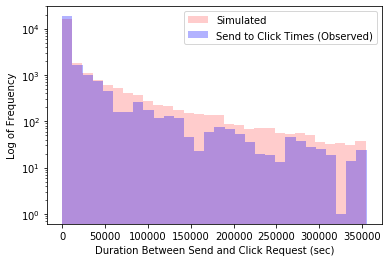

In [12]:
plt.hist(gamma_simulation, bins=30, alpha=0.2, label='Simulated', color='r')
plt.hist(SendRequestSeconds, bins=30, alpha=0.3, label='Send to Click Times (Observed)', color='b')
plt.xlabel('Duration Between Send and Click Request (sec)')
plt.ylabel('Log of Frequency')
plt.yscale('log', nonposy='clip')
plt.legend()
plt.show()

### Results:  
The simulated Gamma function matches very well with the trend of the observed data.  Our first gamma_simulation only using the formulas to estimate alpha and beta looks like a better fit, but it also looks like there might be some over-fitting which tries to adjust for the dips in the observed data 
   
But there are 3 dips in the observed data not seen in the Gamma function.    
The first impressions would be that we don't want to see these dips in the simulated (or predictive) distribution.  Chances are, this would be over-fitting the data.  It would also mean that we would need to find a multi-modal PDF.  
   
Let's see if we find explanation for the dips.  Since this is click data, if these 3 dips correlate to times of the day where we would expect lower than normal click volumes, it would be another factor effecting this distribution.    

In [13]:
from datetime import datetime  
from datetime import timedelta  

estimated_dip_centers = [timedelta(seconds=70000), timedelta(seconds=150000), timedelta(seconds=250000), timedelta(seconds=330000)]
first_send_date = df.SendDate.min()
for dd in estimated_dip_centers:
    print(first_send_date + dd)

2020-01-18 04:29:40
2020-01-19 02:43:00
2020-01-20 06:29:40
2020-01-21 04:43:00


These dips look to be at night.  There are not exact since contacts are distributor over multiple time zones, but this shows that these dips are probably associated lower click volumes associated with off hours for the bulk of contacts.  
  
So, the discovered alpha and beta parameters shows the theoretical PDF for.  Overlaid on this PDF is another feature additive to this PDF that adjusts for lower click volumes after hours.  This second distribution's PDF could be discovered using similar techniques but would probably require additional data to get an accurate UTC activity curve. 

### Below is the theoretical Gamma PDF without using a log y-axis:

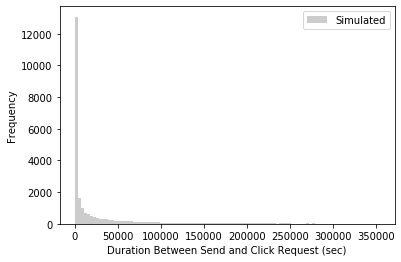

In [15]:
plt.hist(gamma_simulation, bins=100, alpha=0.2, label='Simulated', color='black')
plt.xlabel('Duration Between Send and Click Request (sec)')
plt.ylabel('Frequency')
plt.legend()
plt.show()